# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [37]:
k1 = 8
k2 = 2
p1 = k1/(k1+k2)
p2 = k2/(k1+k2)
H = -(p1 * np.log(p1) + p2 * np.log(p2))
print(round(H, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [38]:
Rl = k1 # в левую вершину попало k1 объектов
Rr = k2 # в правую вершину попало k2 объектов
Rm = k1+k2 # общее количество объектов в корневой вершине поддерева
Hl = k1/k1*(1-k1/k1) # в левой вершине оказалось k1 объектов одного класса, поэтому критерий Джини будет равен нулю (неопределенности вообще нет)
Hr = k2/k2*(1-k2/k2) # в правой вершине оказалось k2 объектов одного класса, поэтому критерий Джини будет равен нулю (неопределенности вообще нет)
Q = H - (Rl/Rm)*Hl - (Rr/Rm)*Hr
print(round(Q, 2))

0.5


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [39]:
pred_array = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
print(np.mean(pred_array))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [17]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [399]:
def get_metric(targets, type_task):
    if type_task == 'regression':
        pred_value = np.mean(targets)
        MSE = np.sum((targets - pred_value)**2)/len(targets)
        return MSE
    else:
        number_of_classes = np.bincount(targets)
        total_classes = len(targets)
        priori_probability = number_of_classes / total_classes
        gini = 1 - np.sum(priori_probability**2)
        return gini


def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if feature_type == 'categorical':
        result = []
        best_Q = -1
        category_best = ''
        unique_categories = np.unique(feature_vector)
        for category in unique_categories:
            left = target_vector[feature_vector == category]
            right = target_vector[feature_vector != category]
            H = get_metric(target_vector, task)
            H_left = get_metric(left, task)
            H_right = get_metric(right, task)
            Q = H - (len(left)/len(target_vector)) * H_left - (len(right)/len(target_vector)) * H_right
            result.append(Q)
            if Q > best_Q:
                best_Q = Q
                category_best = category
        return unique_categories, result, category_best, best_Q 
    else:
        sorted_feature_vector = np.sort(feature_vector)
        all_thresholds = (sorted_feature_vector[:-1] + sorted_feature_vector[1:]) / 2
        result = []
        best_Q = -1
        threshold_best = -1
        thresholds = []
        for threshold in all_thresholds:
            left = target_vector[feature_vector <= threshold]
            right = target_vector[feature_vector > threshold]
            if len(left) == 0 or len(right) == 0:
                continue
            H = get_metric(target_vector, task)
            H_left = get_metric(left, task)
            H_right = get_metric(right, task)
            Q = H - (len(left)/len(target_vector)) * H_left - (len(right)/len(target_vector)) * H_right
            result.append(Q)
            thresholds.append(threshold)
            if Q > best_Q:
                best_Q = Q
                threshold_best = threshold
        result = np.array(result)
        return thresholds, result, threshold_best, best_Q


Эту функцию можно протестировать на датасете `California`.

In [382]:
from sklearn.datasets import fetch_california_housing

In [383]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [384]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [400]:
thresholds, result, threshold_best, _ = find_best_split(feature_vector=X['MedInc'], target_vector=y, task='regression', feature_type='real')

Text(0, 0.5, 'Значение критерия информативности')

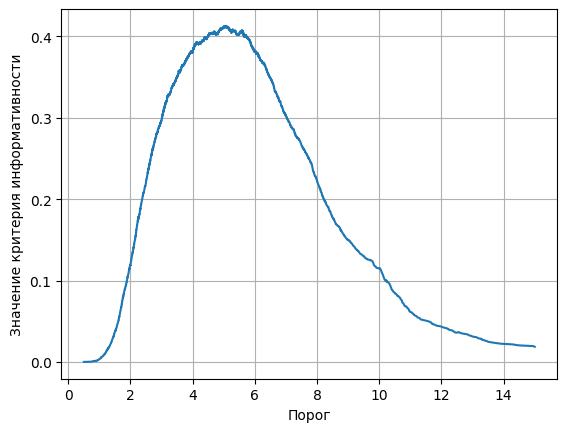

In [401]:
plt.plot(thresholds, result)
plt.grid()
plt.xlabel('Порог')
plt.ylabel('Значение критерия информативности')

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [395]:
threshold_best

5.03515

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [371]:
from sklearn.metrics import accuracy_score, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        
        feature = node['feature_split']
        
        if self._feature_types[feature] == "real":
            if x[feature] <= node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[feature] == 'categorical':
            if x[feature] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        else:
            raise ValueError("Unknown type")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self._fill_na_values(X)
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
    

    def _fill_na_values(self, X):
        for feature in range(X.shape[1]):
            feature_vect = X[:, feature]
            drop_features = []
            if np.sum(np.isnan(feature_vect)) != 0:
                feature_type = self._feature_types[feature]
                percent_na_values = np.sum(np.isnan(feature_vect)) / len(feature_vect)
                if percent_na_values <= 0.3:
                    if feature_type == 'categorical':
                        imputer = SimpleImputer('most_frequent')
                        feature_vect = imputer.fit_transform(feature_vect)
                        X[:, feature] = feature_vect
                    else:
                        imputer = SimpleImputer('median')
                        feature_vect = imputer.fit_transform(feature_vect)
                        X[:, feature] = feature_vect
                elif percent_na_values > 0.3 and percent_na_values < 0.6:
                    imputer = KNNImputer()
                    X = imputer.fit_transform(X)
                else:
                    drop_features.append(feature)
        if len(drop_features) != 0:
            drop_features = np.array(drop_features)
            X = np.delete(X, drop_features, axis=1)
        return X



    def feature_importance(self, X, y, n_repeat=5):
        if len(self._tree) == 0:
            raise ValueError("The tree has not been trained yet")
        
        # Исходная метрика на оригинальных данных
        if self.task == 'classification':
            initial_metric = accuracy_score(y, self.predict(X))
        else:
            initial_metric = r2_score(y, self.predict(X))
        

        # Перебор признаков для оценки важности
        for feature in range(X.shape[1]):
            # Список для хранения метрик на перемешанных данных
            metrics = []
            X_copy = np.copy(X)

            for i in range(n_repeat):
                # Создаем копию X и перемешиваем значения текущего признака
                
                np.random.shuffle(X_copy[:, feature])

                # Оцениваем метрику на данных с перемешанным признаком
                if self.task == 'classification':
                    metric = accuracy_score(y, self.predict(X_copy))
                else:
                    metric = r2_score(y, self.predict(X_copy))

                metrics.append(metric)

            # Рассчитываем среднее отклонение от исходной метрики
            mean_metric = np.mean(metrics)
            difference = initial_metric - mean_metric

            # Сохраняем важность признака
            self._feature_importances[feature] = difference

        return self._feature_importances


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

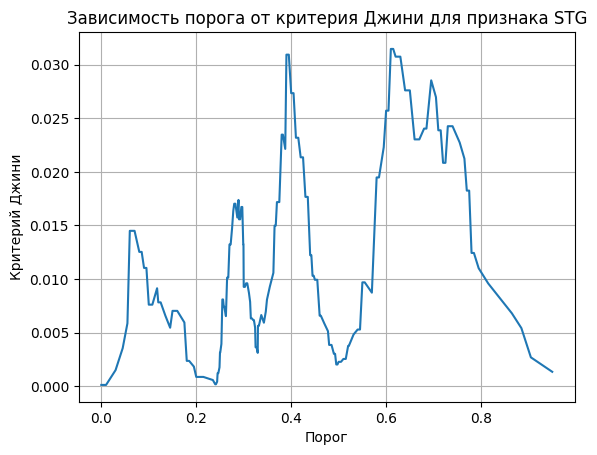

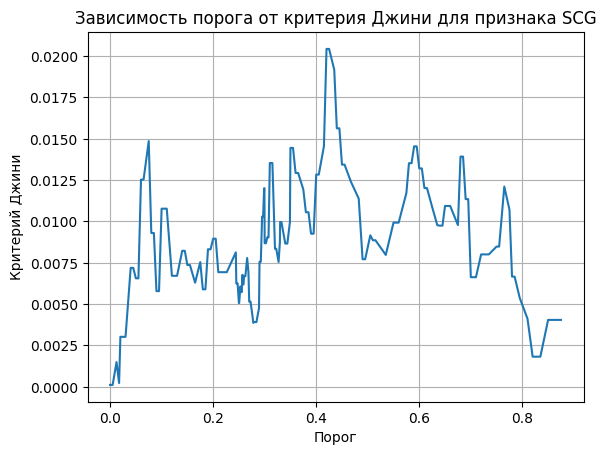

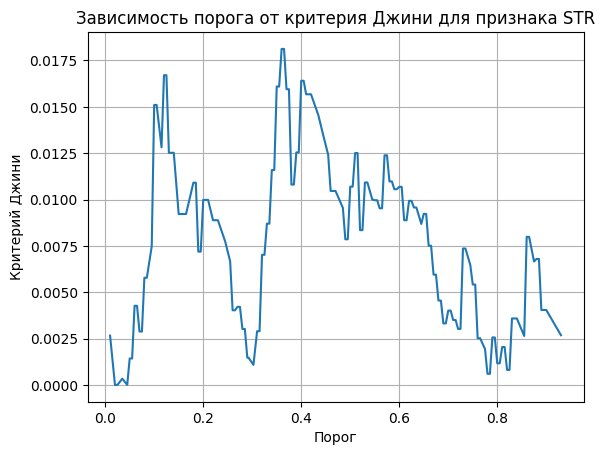

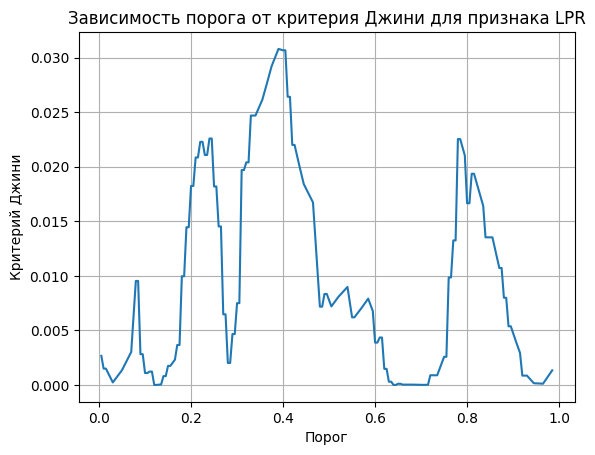

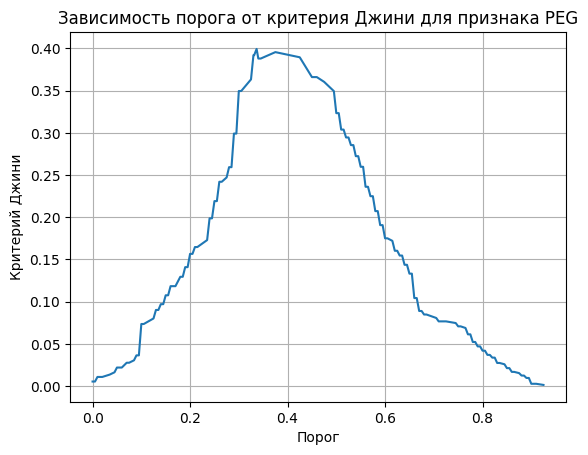

In [107]:
df = pd.read_csv('Data/students.csv')
df.drop(columns='Unnamed: 0', inplace=True)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
for feature in X.columns:
    thresholds, gini_criteries, _, _ = find_best_split(X[feature], y)
    plt.plot(thresholds, gini_criteries)
    plt.title(f"Зависимость порога от критерия Джини для признака {feature}")
    plt.xlabel("Порог")
    plt.ylabel("Критерий Джини")
    plt.grid()
    plt.show()


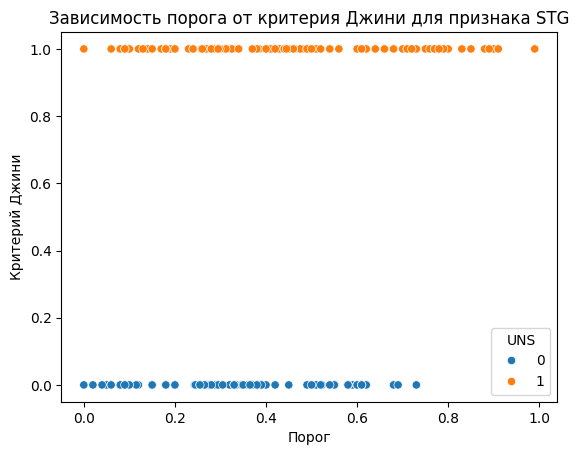

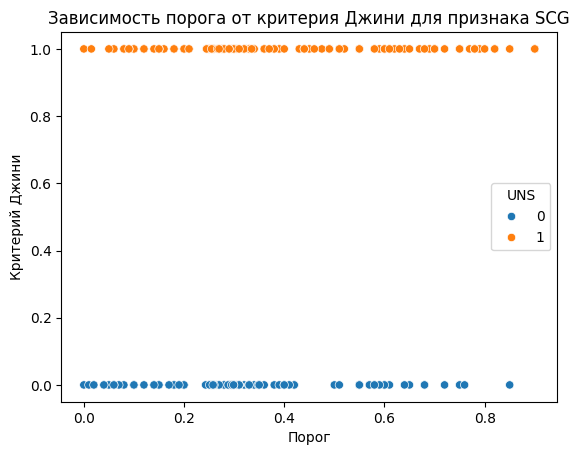

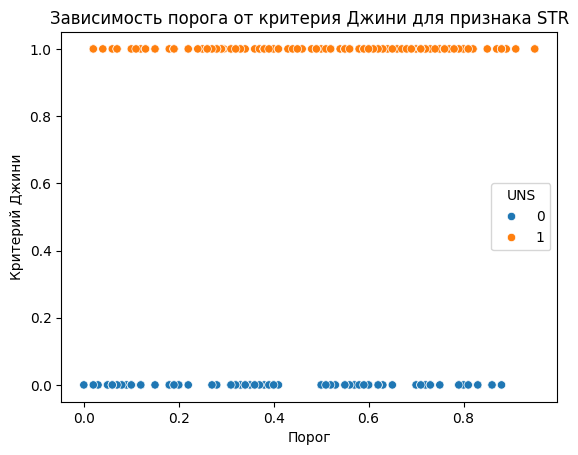

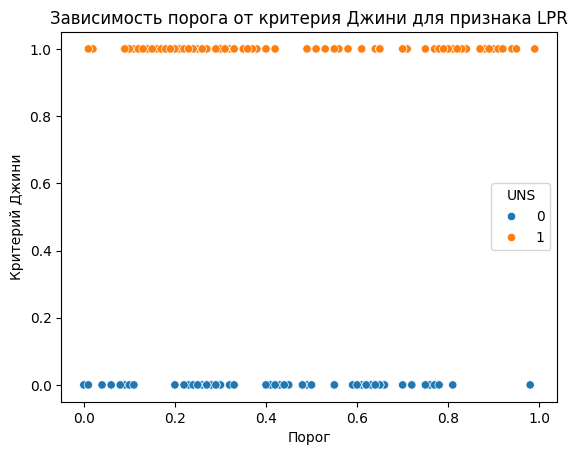

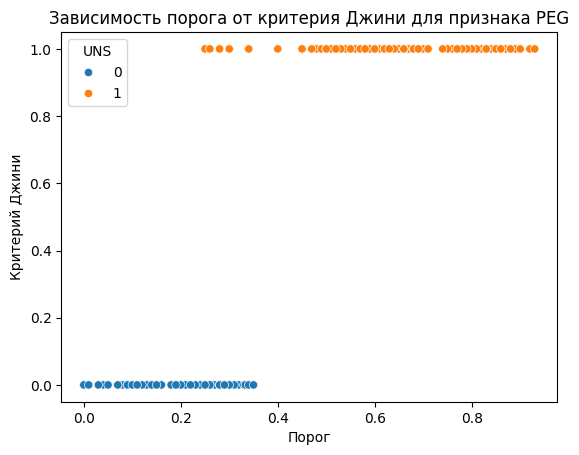

In [110]:
for feature in X.columns:
    # thresholds, gini_criteries, _, _ = find_best_split(X[feature], y)
    sns.scatterplot(data=df, x=feature, y='UNS', hue='UNS')
    plt.title(f"Зависимость порога от критерия Джини для признака {feature}")
    plt.xlabel("Порог")
    plt.ylabel("Критерий Джини")
    plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых зависимостей, можно сказать, что необходимо делить выборку по признаку PEG, так как оно имеет только один пик, в котором разделение наиболее четкое. При слишком низком или высоком пороге обе группы могут смешаны, и информативность низкая. Подтверждение можно увидеть на графики рассеяния для этого признака. По нему видно, что при пороге равеом примерно 0.38 можно практически идеально отделить синий класс от оранжевого. Поэтому наиболее информативный признак будет иметь распределение близкое к нормальному. Для плохого (неинформативного) признака график зависимости критерия информативности от порогового значения будет иметь много пиковых значений, которые характеризуют случайное разделение по данному признаку и не отражают его важность при разделении классов. Его распределение с увеличением выборки будет приближаться к равномерному. В данном случае плохим признаком является SCG, так значение критерия информативности нестабильно при изменении порогоа, то есть сначала с увеличением порога критерий растет, а потом резко начинает падать и наоборот. Это происходит из-за случайности и характера обучающей выборки.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [374]:
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("Data/agaricus-lepiota.data", header=None, na_values="?")
df = df.apply(LabelEncoder().fit_transform)
df_train = df.sample(len(df)//2)
df_test = df.drop(df_train.index)
df_train.head()
X_train = df_train.iloc[:, 1:]
X_train = X_train.to_numpy()
X_test = df_test.iloc[:, 1:]
X_test = X_test.to_numpy()
y_train = df_train.iloc[:, 0]
y_train = y_train.to_numpy()
y_test = df_test.iloc[:, 0]
y_test = y_test.to_numpy()
feature_type = ["categorical"] * X_train.shape[1]
my_tree = DecisionTree(feature_types=feature_type)
my_tree.fit(X_train, y_train)

In [375]:
from sklearn.metrics import accuracy_score
predictions_test = my_tree.predict(X_test)
print(f"Accuracy на тестовой выборке {accuracy_score(y_test, predictions_test)}")

Accuracy на тестовой выборке 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [193]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [194]:
data = pd.read_csv('Data/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

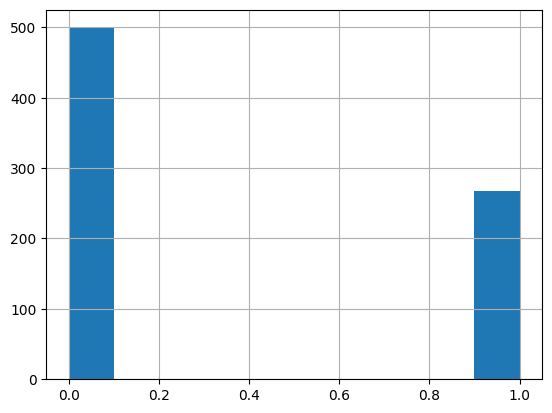

In [195]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [259]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
print(f"Объем обучающей выборки (доля от исходного датасета): {round(len(X_train)/len(X), 2)}")
print(f"Объем валидационной выборки (доля от исходного датасета): {round(len(X_val)/len(X), 2)}")
print(f"Объем тестовой выборки (доля от исходного датасета): {round(len(X_test)/len(X), 2)}")

Объем обучающей выборки (доля от исходного датасета): 0.49
Объем валидационной выборки (доля от исходного датасета): 0.21
Объем тестовой выборки (доля от исходного датасета): 0.3


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [265]:
import itertools
max_depths = np.arange(1, 21, 2)
min_sample_leafs = np.arange(1, 11)
combinations = list(itertools.product(max_depths, min_sample_leafs))
best_f1 = 0
best_max_depth = 1
best_min_sample_leaf = 1
for combo in combinations:
    max_depth = combo[0]
    min_sample_leaf = combo[1]
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_sample_leaf)
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1:
        best_f1 = f1
        best_max_depth = max_depth
        best_min_sample_leaf = best_min_sample_leaf

best_model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_sample_leaf)
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)
print(f"Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision на тестовой выборке: {precision_score(y_test, y_pred_test)}")
print(f"Recall на тестовой выборке: {recall_score(y_test, y_pred_test)}")
print(f"Roc_auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba_test[:, 1])}")


Accuracy на тестовой выборке: 0.7272727272727273
Precision на тестовой выборке: 0.5774647887323944
Recall на тестовой выборке: 0.5540540540540541
Roc_auc на тестовой выборке: 0.6797211223962817


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [266]:
model_bag = BaggingClassifier(n_estimators=50)
model_bag.fit(X_train, y_train)
y_pred_test = model_bag.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)
print(f"Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision на тестовой выборке: {precision_score(y_test, y_pred_test)}")
print(f"Recall на тестовой выборке: {recall_score(y_test, y_pred_test)}")
print(f"Roc_auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba_test[:, 1])}")

Accuracy на тестовой выборке: 0.7532467532467533
Precision на тестовой выборке: 0.6307692307692307
Recall на тестовой выборке: 0.5540540540540541
Roc_auc на тестовой выборке: 0.6797211223962817


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [267]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
min_samples_splits = np.arange(1, 11)
params = {'max_depth': max_depths, 'min_samples_split': min_samples_splits}
grid_search = GridSearchCV(estimator=RandomForestClassifier(n_estimators=50), param_grid=params, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)
y_pred_proba_test = best_model.predict_proba(X_test)
print(f"Accuracy на тестовой выборке: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision на тестовой выборке: {precision_score(y_test, y_pred_test)}")
print(f"Recall на тестовой выборке: {recall_score(y_test, y_pred_test)}")
print(f"Roc_auc на тестовой выборке: {roc_auc_score(y_test, y_pred_proba_test[:, 1])}")


Accuracy на тестовой выборке: 0.7662337662337663
Precision на тестовой выборке: 0.6666666666666666
Recall на тестовой выборке: 0.5405405405405406
Roc_auc на тестовой выборке: 0.8239800309864004


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Text(0, 0.5, 'Метрика AUC ROC')

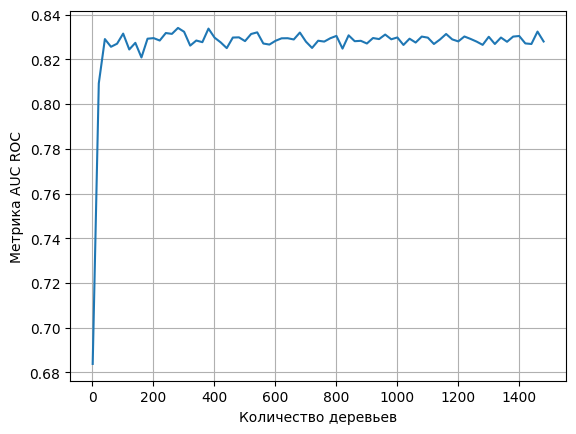

In [268]:
estimators = np.arange(1, 1500, 20)
scores = []
for estimator in estimators:
    model = RandomForestClassifier(n_estimators=estimator)
    model.fit(X_train, y_train)
    y_pred_proba_test = model.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred_proba_test[:, 1])
    scores.append(score)
plt.plot(estimators, scores)
plt.xlabel('Количество деревьев')
plt.grid()
plt.ylabel('Метрика AUC ROC')
# Вывод: С увеличением количества деревьев в лесу, метрика auc roc выходи на асимптоту, то есть практически не изменяется

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<Axes: xlabel='None'>

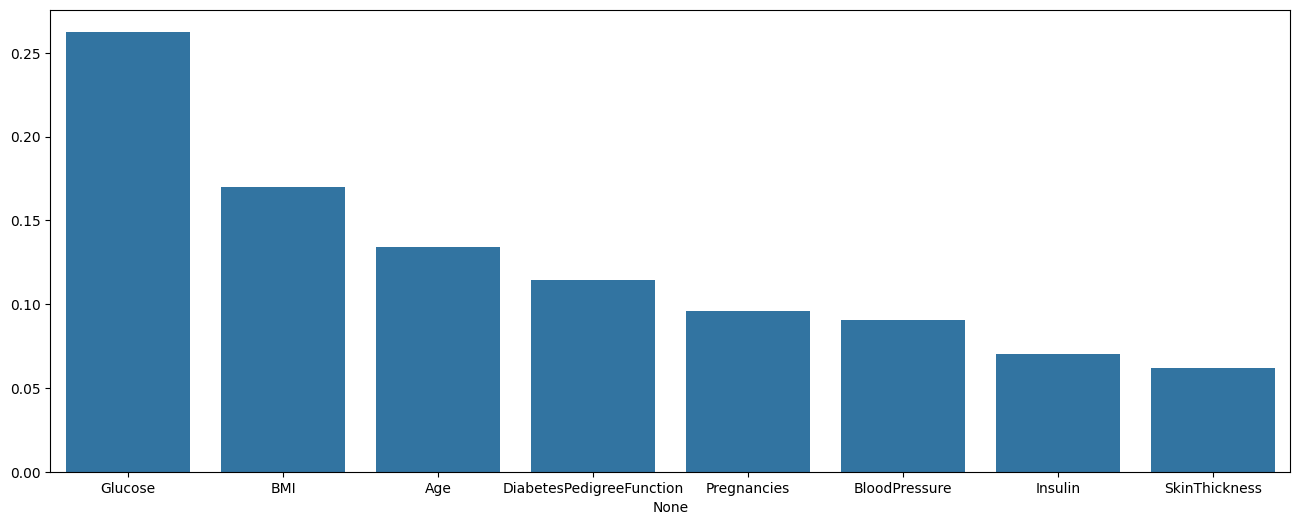

In [ ]:
plt.figure(figsize=(16, 6))
feature_names = X_train.columns
feature_importance = np.argsort(best_model.feature_importances_)[::-1]
feature_names_idx = feature_names[feature_importance]
sns.barplot(x=feature_names_idx, y=np.sort(best_model.feature_importances_)[::-1])
# Самый важный признак - глюкоза